In [11]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from datetime import datetime
from scipy.sparse import csr_matrix
from sklearn import datasets, svm, metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
n_events = 300 # Each event actually produces one gamma ray shower and one cosmic ray shower as per the for loop below,
n_pmt = 60     # meaning the total number of events will be twice the input value n_events

targets = np.arange(0, 2, 1)
increment_targets = np.arange(0, 2, 1)
all_images = np.zeros((n_events * 2, 72, 72))
print(all_images.shape)

for i in range(n_events):
    gamma, ray_1 = make_gaussian_quantiles(mean = (10,10), cov = 1.2,
                                             n_samples = n_pmt, n_features = 2,
                                             n_classes = 1, random_state = i) 

    cosmic, ray_2 = make_gaussian_quantiles(mean = (9, 9), cov = 1.4,
                                             n_samples = n_pmt, n_features = 2,
                                             n_classes = 1, random_state = i + 2)
    
    for j in enumerate(gamma):
        event_i.append(list(zip(gamma[:, 0][j], gamma[:, 1][j])))

    # This is slightly confusing, make_gaussian_quantiles defines the variable x as an n x 2 matrix of x, y coordinates
    # Now, I'm simply separating that matrix into two arrays: one array of x coordinates, one array of y coordinates

    gammax_array = gamma[:, 0]
    gammay_array = gamma[:, 1]

    cosmicx_array = cosmic[:, 0]
    cosmicy_array = cosmic[:, 1]

    detection = np.arange(0, n_pmt, 1)

    # At some point, ask Udara on what grid system HAWC is built.  Hopefully, the origin is not in the center. 
    # I think I can define it myself... 

    for j in range(n_pmt):
        detection[j] = 1
        gammax_array[j] = "{0:1f}".format(gammax_array[j])
        gammay_array[j] = "{0:1f}".format(gammay_array[j])
        cosmicx_array[j] = "{0:1f}".format(cosmicx_array[j])
        cosmicy_array[j] = "{0:1f}".format(cosmicy_array[j])

    pixels = np.arange(0, 72, 1)
    gammax_indeces = gammax_array * 4
    gammay_indeces = gammay_array * 4
    cosmicx_indeces = cosmicx_array * 4
    cosmicy_indeces = cosmicy_array * 4
    
    all_indeces = [gammax_indeces, gammay_indeces, cosmicx_indeces, cosmicy_indeces]
    
    for k in range(n_pmt):
        for l, idx in zip(range(4), all_indeces):
            if idx[k] > 71:
                idx[k] = 71.
            elif idx[k] < 0.:
                idx[k] = 0.
        for m, idx2 in zip(range(n_pmt), all_indeces):
            if idx2[k] == idx2[m]:
                idx2[k] += 1

    gamma_both = list(zip(gammax_indeces, gammay_indeces))
    cosmic_both = list(zip(cosmicx_indeces, cosmicy_indeces))
    
    gammax_min, gammax_max = gammax_indeces.min() - 4, gammax_indeces.max() + 4
    gammay_min, gammay_max = gammay_indeces.min() - 4, gammay_indeces.max() + 4
    cosmicx_min, cosmicx_max = cosmicx_indeces.min() - 4, cosmicx_indeces.max() + 4
    cosmicy_min, cosmicy_max = cosmicy_indeces.min() - 4, cosmicy_indeces.max() + 4
    
    # Come back to this, these arrays should probably be one and the same for the purpose of training the algorithm
    gamma_image = csr_matrix((detection, (gammax_indeces, gammay_indeces)), shape = (len(pixels), len(pixels))).toarray() #These parentheses are important
    cosmic_image = csr_matrix((detection, (cosmicx_indeces, cosmicy_indeces)), shape = (len(pixels), len(pixels))).toarray()
    
#     print(gamma_image)

    all_images[2 * i] = gamma_image
    all_images[(2 * i) + 1] = cosmic_image
    
    if i == 0: 
        i = 0
    else:
        targets = np.concatenate((targets, increment_targets))
        
images_targets = list(zip(all_images, targets))

(600, 72, 72)


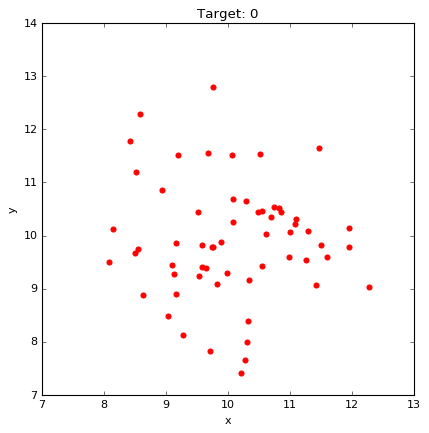

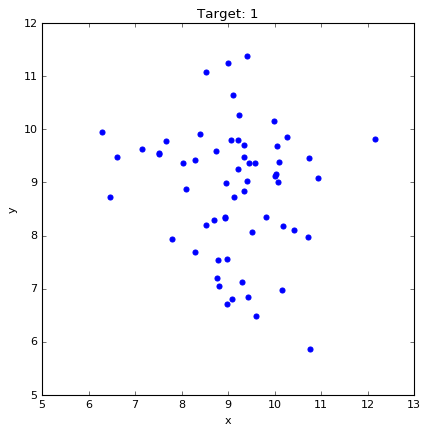

In [17]:
# Just to make sure everything seems to be working correctly

plt.figure(figsize = (6, 6))
plt.scatter(gammax_array, gammay_array, color = 'r')
plt.autoscale(enable = True, axis = 'both')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target: 0' %target)
plt.show()

plt.figure(figsize = (6, 6))
plt.scatter(cosmicx_array, cosmicy_array, color = 'b')
plt.autoscale(enable = True, axis = 'both')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target: 1' %target)
plt.show()   

In [4]:
# Reshape the image to go through classifier
data = all_images.reshape((n_events * 2, -1))

print(data[:n_events].shape)

# Classifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3),
                        algorithm  = "SAMME",
                        n_estimators = 500)

# Train the algorithm
bdt.fit(data[:n_events], targets[:n_events])

(300, 5184)


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=500, random_state=None)

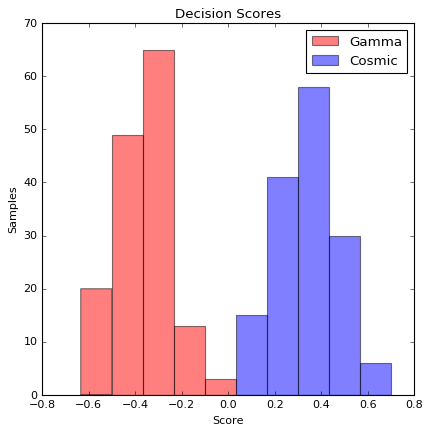

In [5]:
predicted = bdt.predict(data[n_events:])

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(data[n_events:])
plot_range = (twoclass_output.min(), twoclass_output.max())
class_names = "Gamma", "Cosmic"
plot_colors = "rb"
plt.figure(figsize = (6, 6))

for o, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[targets[:n_events] == o],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='%s' % n, # This is a useful tool
             alpha=.5,
             edgecolor='k')
    
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.show()

In [6]:
#print(twoclass_output)
print(targets[n_events:].reshape(30, -1))

good_score = 0
bad_score  = 0

for p, score, target in zip(range(n_events), twoclass_output, targets[n_events:]):
    if score < 0 and target == 0:
        good_score += 1
    elif score > 0 and target == 1: 
        good_score += 1
    else:
        bad_score += 1
        
print(good_score)
print(bad_score)

[[0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]]
300
0
